In [1]:
import numpy as np
import pandas as pd

import statsmodels.api as sm

import matplotlib.pyplot as plt 
%matplotlib inline
import tensorflow_hub as hub

import random as rand
import ast
import math
import warnings
warnings.filterwarnings('ignore')

import tensorflow_hub as hub
embed = hub.load(r"C:\\Users\learn\Downloads\universal-sentence-encoder_4")

In [2]:
df = pd.read_csv('may_12.csv')
df['revenue_m'] = df['Revenue in 2023'] / 1000000

# DF INFO
# df.head()
# df.info()

In [3]:
lists = ['companies_clean_list','countries_clean_list','genres_clean_list','keywords_clean_list'
        ,'cast_clean_list','crew_clean_list','cast_short_list','crew_short_list']
def help1(x):
    return ast.literal_eval(x)
for i in lists:
    df[i] = df[i].apply(help1)

feature_names = df.columns
for i in range(len(feature_names)):
    print(str(i), "\t", str(feature_names[i]),"\t\t\t", str(type(df.iloc[0,i])))

0 	 id 			 <class 'numpy.int64'>
1 	 release_date 			 <class 'str'>
2 	 runtime 			 <class 'numpy.float64'>
3 	 title 			 <class 'str'>
4 	 vote_average 			 <class 'numpy.float64'>
5 	 vote_count 			 <class 'numpy.int64'>
6 	 Year 			 <class 'numpy.int64'>
7 	 Month 			 <class 'numpy.int64'>
8 	 Revenue in 2023 			 <class 'numpy.float64'>
9 	 Budget in 2023 			 <class 'numpy.float64'>
10 	 overview 			 <class 'str'>
11 	 collect_clean 			 <class 'str'>
12 	 genres_clean_list 			 <class 'list'>
13 	 companies_clean_list 			 <class 'list'>
14 	 countries_clean_list 			 <class 'list'>
15 	 keywords_clean_list 			 <class 'list'>
16 	 cast_clean_list 			 <class 'list'>
17 	 crew_clean_list 			 <class 'list'>
18 	 cast_short_list 			 <class 'list'>
19 	 crew_short_list 			 <class 'list'>
20 	 cast_short_freq 			 <class 'numpy.float64'>
21 	 crew_short_freq 			 <class 'numpy.float64'>
22 	 companies_freq 			 <class 'numpy.float64'>
23 	 revenue_m 			 <class 'numpy.float64'>


In [4]:
df = df.sample(frac = 1)
# drop_titles = ['Cinderella', 'Alice in Wonderland', 'Gone with the wind', 'Bambi', 'Snow White and the Seven Dwarfs']
# df = df[~df['title'].isin(drop_titles)]
df = df[df['Revenue in 2023'] <= 529000000]
df = df[df['Revenue in 2023'] > 1000]
df = df[df['Budget in 2023'] > 1000]
df = df[df['Year'] > 2000]

# df = df[df['Revenue in 2023'] >= 1000000]

train_proportion = 0.8
n = len(df)
print('Size of dataset: ', str(n))
t = int(train_proportion * n)
# t = 4000

def cast_parse(string):
#     print(f'Original String: {string}')
    box = string.replace('\n','').replace("' ","', ")
#     return box
    return ast.literal_eval(box)

target = df['revenue_m']

revenue_columns = ['revenue_m', 'revenue', 'Revenue in 2023', 'ROI']
data = df.loc[:, ~df.columns.isin(revenue_columns)]

train_x = data.iloc[0:t]
test_x = data.iloc[t:]
train_y = target[0:t]
test_y = target[t:]

labels_real = [
    'Budget in 2023',
    'runtime'
]
train_vals = np.asarray(train_x.loc[:, labels_real])
test_vals = np.asarray(test_x.loc[:, labels_real])

offset = np.ones((train_vals.shape[0], 1))
train_vals = np.concatenate((train_vals,offset), axis=1)

offset = np.ones((test_vals.shape[0], 1))
test_vals = np.concatenate((test_vals,offset), axis=1)

print(train_x.shape)
print(test_x.shape)

Size of dataset:  2371
(1896, 22)
(475, 22)


In [5]:
def MSE(y, pred):
    n = len(y)
    error_sum = 0
    for i in range(n):
        error = y.iloc[i] - pred[i]
        error = error ** 2
        error_sum += error
        
    return (error_sum / n)

def plotDiagonal(xmin, xmax):
    xsamples = np.arange(xmin,xmax,step=0.01)
    plt.plot(xsamples,xsamples,c='black')

def plotdata(x=None,y=None,xname=None,yname=None,margin=0.05,plotDiag=True,zeromin=False):
    plt.scatter(x,y,label='data')
    plt.xlabel(xname)
    plt.ylabel(yname)
    range_x = max(x) - min(x)
    range_y = max(y) - min(y)
    if plotDiag:
        plotDiagonal(min(x)-margin*range_x,max(x)+margin*range_x)
    if zeromin:
        plt.xlim(0.0,max(x)+margin*range_x)
        plt.ylim(0.0,max(y)+margin*range_y)
    else:
        plt.xlim(min(x)-margin*range_x,max(x)+margin*range_x)
        plt.ylim(min(y)-margin*range_y,max(y)+margin*range_y)
    plt.show()
    
def plot_pred_true(test_pred=None, test_y=None, max_points = 1000):
    plotdata(test_pred[1:max_points], test_y[1:max_points],'Predicted', 'True', zeromin=True)
    
def run_OLS(train_y, test_y, train_vals, test_vals):
    ols_model = sm.regression.linear_model.OLS(train_y, train_vals)
    while True: # Bypasses SVD convergence assertion error
        try:
            results = ols_model.fit()
            break
        except:
            None   
    w = np.array(results.params).reshape([len(results.params),1])
    train_pred = np.matmul(train_vals,w)
    test_pred = np.matmul(test_vals,w)
    train_MSE = MSE(train_y, train_pred.flatten())
    test_MSE = MSE(test_y, test_pred.flatten())
    return train_MSE, test_MSE, test_pred

def run_OLSreg(train_y, test_y, train_vals, test_vals, alpha=1, L1_wt=1):
    lasso_model = sm.GLM(train_y, train_vals, family=sm.families.Gaussian())
    while True: # Bypasses SVD convergence assertion error
        try:
            results = lasso_model.fit_regularized(method='elastic_net', alpha=alpha, L1_wt=L1_wt)
            break
        except:
            None
    w = np.array(results.params).reshape([len(results.params),1])
    train_pred = np.matmul(train_vals,w)
    test_pred = np.matmul(test_vals,w)
    train_MSE = MSE(train_y, train_pred.flatten())
    test_MSE = MSE(test_y, test_pred.flatten())
    return train_MSE, test_MSE, test_pred

In [6]:
train_MSE, test_MSE, test_pred = run_OLS(train_y, test_y, train_vals, test_vals)

Train MSE	 7774.475752696066
Test MSE	 7338.818481637176


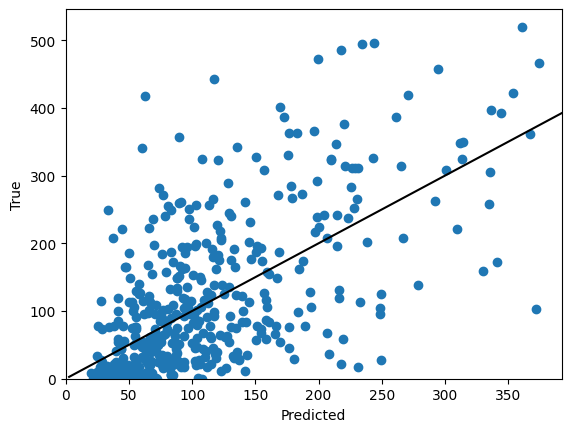

In [7]:
print("Train MSE\t", str(train_MSE))
print("Test MSE\t", str(test_MSE))

plot_pred_true(test_pred.flatten(), test_y) #.flatten() will make sure the dimensions match

In [8]:
def manyhot(column=None, col=None):
    vic = {}
    for i in range(len(col)):
        vic[col[i]] = i
    for e in range(len(column)):
        arr = [0] * (len(col))
        for v in column[e]:
            try:
                arr[vic[v]] = 1
            except:
                pass
        column[e] = arr
    column = column.tolist()
    column = np.array(column)
    return column

def parse_str(string):
    string = string.replace("[", "['")
    string = string.replace("]", "']")
    string = string.replace(" ", "', '")
    string = np.array((string))
    return string

def newParse(string):
    return ast.literal_eval(string)

def addmanyhot(original_train,original_test,column_name): 
    train_set_vals = train_x.loc[:, column_name]
    test_set_vals = test_x.loc[:, column_name]
    vtypes = train_set_vals.explode().unique()

    train_set_vals = np.array(train_set_vals)
    train_set_vals = manyhot(train_set_vals, vtypes)

    test_set_vals = np.array(test_set_vals)
    test_set_vals = manyhot(test_set_vals, vtypes)

    original_train = np.concatenate((original_train,train_set_vals), axis=1)
    original_test = np.concatenate((original_test,test_set_vals), axis=1)
    
    return original_train, original_test, train_set_vals, test_set_vals

In [9]:
print(train_vals.shape)
train_vals, test_vals, a, b = addmanyhot(train_vals,test_vals, 'genres_clean_list')
print(train_vals.shape)

(1896, 3)
(1896, 23)


In [10]:
# train_MSE, test_MSE, test_pred = run_OLSreg(train_y, test_y, train_vals, test_vals,1 ,1)
train_MSE, test_MSE, test_pred = run_OLS(train_y, test_y, train_vals, test_vals)

Train MSE	 7406.888869821448
Test MSE	 7107.5416122557535


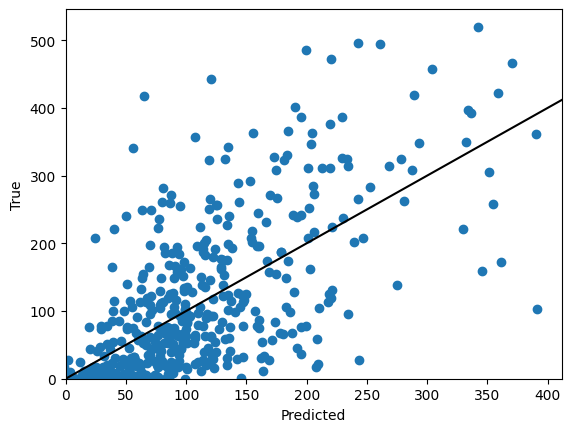

In [11]:
print("Train MSE\t", str(train_MSE))
print("Test MSE\t", str(test_MSE))
plot_pred_true(test_pred.flatten(), test_y)

In [12]:
freqs = ['cast_short_freq','crew_short_freq','companies_freq']
freqs_train = train_x.loc[:,freqs]
freqs_test = test_x.loc[:,freqs]

# JUST 
print(train_vals.shape)

train_vals = np.concatenate((train_vals,freqs_train),axis=1)
test_vals = np.concatenate((test_vals,freqs_test),axis=1)
print(train_vals.shape)

(1896, 23)
(1896, 26)


In [13]:
train_MSE, test_MSE, test_pred = run_OLS(train_y, test_y, train_vals, test_vals)
# print(train_vals)

Train MSE	 7125.116115336405
Test MSE	 6718.8158228340135


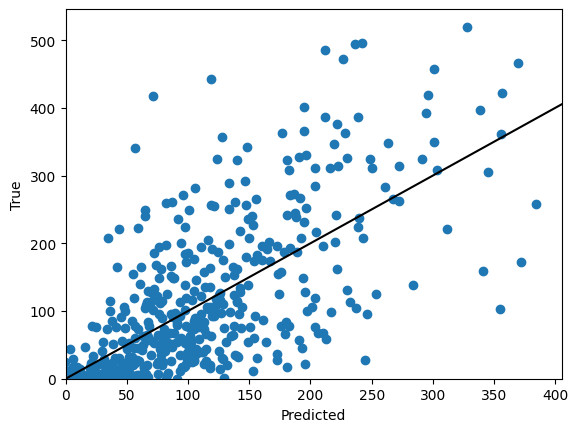

In [14]:
print("Train MSE\t", str(train_MSE))
print("Test MSE\t", str(test_MSE))
plot_pred_true(test_pred.flatten(), test_y)

In [15]:
# TAKES A SAMPLE OF A SET OF FEATURES (USE FOR MANYHOT)
def sample(train,test,ratio):
    sample_ratio = ratio
    columns_to_sample = int(round(sample_ratio * train.shape[1]))
    idx_cols_to_sample = rand.sample(list(range(len(train[0]))), columns_to_sample)
    sampled_columns = train[:,idx_cols_to_sample]
    
    columns_to_sample2 = int(round(sample_ratio * test.shape[1]))
    idx_cols_to_sample2 = rand.sample(list(range(len(test[0]))), columns_to_sample2)
    sampled_columns2 = test[:,idx_cols_to_sample2]
    return sampled_columns, sampled_columns2


In [16]:
overview_train = []
overview_test = []

for i in range(len(train_x)):
    overview_train.append(str(train_x["overview"].iloc[i]))
for i in range(len(test_x)):
    overview_test.append(str(test_x["overview"].iloc[i]))

embeddings_train_overview = embed(overview_train)
embeddings_test_overview = embed(overview_test)

print(embeddings_train_overview.shape)

train_vals_overview = np.concatenate((train_vals,embeddings_train_overview), axis=1)
test_vals_overview = np.concatenate((test_vals,embeddings_test_overview), axis=1)

(1896, 512)


In [17]:
print(train_vals_overview.shape)

(1896, 538)


In [18]:
# train_MSE, test_MSE, test_pred = run_OLS(train_y, test_y, train_vals_overview, test_vals_overview)
train_MSE, test_MSE, test_pred = run_OLSreg(train_y, test_y, train_vals_overview, test_vals_overview, .1, 1)

Train MSE	 6740.5441868029
Test MSE	 6835.730750064779


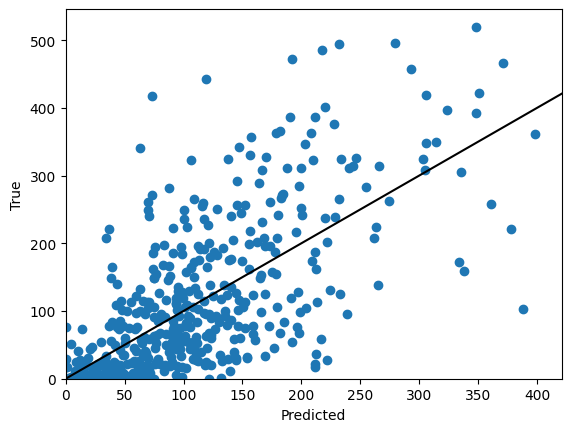

In [20]:
# print(train_vals)
print("Train MSE\t", str(train_MSE))
print("Test MSE\t", str(test_MSE))
plot_pred_true(test_pred.flatten(), test_y)

In [21]:
title_train = []
title_test = []

for i in range(len(train_x)):
    title_train.append(str(train_x["title"].iloc[i]))
for i in range(len(test_x)):
    title_test.append(str(test_x["title"].iloc[i]))

embeddings_train_title = embed(title_train)
embeddings_test_title = embed(title_test)

# print(embeddings_train)
print(embeddings_train_title.shape)
# print(train_x.shape)
# print(test_x.shape)

train_vals_title = np.concatenate((train_vals,embeddings_train_title), axis=1)
test_vals_title = np.concatenate((test_vals,embeddings_test_title), axis=1)

print(train_vals_title.shape)

(1896, 512)
(1896, 538)


In [22]:
# train_MSE, test_MSE, test_pred = run_OLS(train_y, test_y, train_vals_title, test_vals_title)
train_MSE, test_MSE, test_pred = run_OLSreg(train_y, test_y, train_vals_title, test_vals_title, .09, 1)
print(train_vals_title.shape)

(1896, 538)


Train MSE	 5923.085203491577
Test MSE	 6168.33823326278


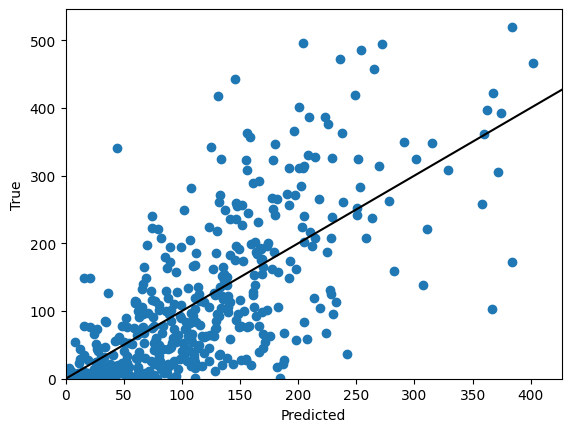

In [23]:
# print(train_vals)
print("Train MSE\t", str(train_MSE))
print("Test MSE\t", str(test_MSE))
plot_pred_true(test_pred.flatten(), test_y)

In [25]:
train_set_vals = train_x.loc[:, 'cast_short_list']
test_set_vals = test_x.loc[:, 'cast_short_list']

# print(train_set_vals[0])
# print(type(train_set_vals[0]))

vtypes = train_set_vals.explode().unique()
# print('Val Kilmer' in vtypes)

print(len(vtypes))
print(vtypes)

train_set_vals = np.array(train_set_vals)
train_set_vals = manyhot(train_set_vals, vtypes)

test_set_vals = np.array(test_set_vals)
test_set_vals = manyhot(test_set_vals, vtypes)

train_vals_cast = np.concatenate((train_vals,train_set_vals), axis=1)
test_vals_cast = np.concatenate((test_vals,test_set_vals), axis=1)

2432
['Rob Corddry' 'Craig Robinson' 'Clark Duke' ... 'Felicity Huffman'
 'Elizabeth Peña' 'Bebe Neuwirth']


In [26]:
print(train_vals_cast.shape)

(1896, 2458)


In [27]:
train_MSE, test_MSE, test_pred = run_OLSreg(train_y, test_y, train_vals_cast, test_vals_cast, .2, 1)

Train MSE	 6476.543670538175
Test MSE	 7257.978503250335


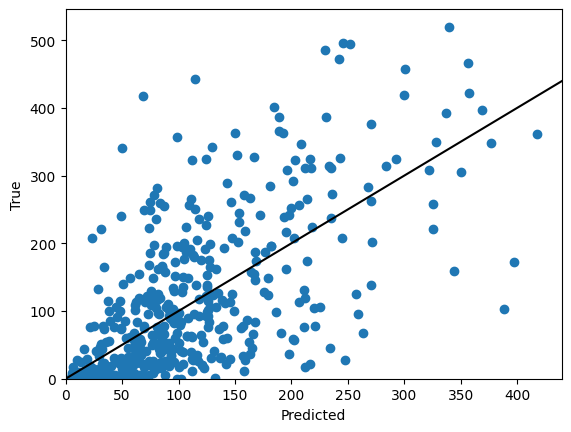

In [28]:
print("Train MSE\t", str(train_MSE))
print("Test MSE\t", str(test_MSE))

plot_pred_true(test_pred.flatten(), test_y)

In [29]:
print(train_vals.shape)

(1896, 26)


In [30]:
# def newParse(x):
#     return np.asarray(x)

# genress = train_x.loc[:, 'genres_clean'].apply(newParse)
# companies = train_x.loc[:, 'companies_clean'].apply(newParse)
# for i in companies:
#     print(i)

In [ ]:
# relevant = pd.read_csv('complete_short_data.csv')
# box = relevant['revenue']

# relevant['revenue'] = relevant['Revenue in 2023']
# relevant['budget'] = relevant['Budget in 2023']

# # relevant.loc[relevant['id'] == 8856, 'budget'] = 13000000
# # relevant.loc[relevant['id'] == 3082, 'budget'] = 1500000

# # relevant.loc[8856, 'budget'] = 13000000
# # relevant.loc[2667, 'budget'] = 1500000
# print(relevant['Budget in 2023'])
# relevant['success'] = relevant['Revenue in 2023'] / relevant['Budget in 2023']
# relevant['difference'] = (relevant['Revenue in 2023'] - relevant['revenue']) 

# print(relevant['difference'].mean() / len(relevant['difference']))

# print(relevant['difference'])
# # print(relevant)
# dic = {}
# for i in range(len(relevant)):
#     try:
#         g_list = ast.literal_eval(relevant['genres'][i])
# #         print(g_list)
#         for j in g_list:
#             if j['name'] in dic:
#                 if relevant['success'][i] > 1000:
#                     pass
#                 else:
#                     dic[j['name']].append(relevant['success'][i])
#             else:
#                 if relevant['success'][i] > 1000:
#                     pass
#                 else:
#                     dic[j['name']] = [relevant['success'][i]]
#     except:
#         pass

# # print(dic)
# # print(dic)
# # print(max(dic['Crime']))

# for i in dic:
# #     print(i)
# #     print(sum(dic[i]))
# #     print(len(dic[i]))
#     dic[i] = sum(dic[i])/len(dic[i])
    
# cat = list(dic.keys())
# avg_succ = list(dic.values())
# # avg_succ = [sum(i)/len(i) for i in avg_succ]

# # print(cat)
# # print(avg_succ)

# data = {'Genres': cat, 'Frequencies': avg_succ}
# dd = pd.DataFrame(data)
# dd = dd.sort_values('Frequencies', ascending=False)

# # print(dd)
# plt.figure(figsize=(15, 6))
# # plt.setp(ax.get_xticklabels(), fontsize=10, rotation='vertical')

# my_colors = ['b', 'b', 'g', 'g', 'g','g', 'g', 'g', 'g', 'g','g', 'r', 'r', 'r', 'r','r','r','r']

# plt.bar(dd['Genres'], dd['Frequencies'], color=my_colors)
# plt.xlabel('Genres')
# plt.ylabel('Revenue Margins')
# plt.title('Reveneue Margins of each genre (Excluding outliers)')

# plt.xticks(rotation=70)

# # print(len(relevant))
# plt.show()

# g_list = list(genres)
# g_list = [ast.literal_eval(i) for i in g_list]

# genre_frequency = {}

# for i in g_list:
#     for j in i:
#         if (j['name'] in genre_frequency):
#             genre_frequency[j['name']] += 1
#         else:
#             genre_frequency[j['name']] = 1

# Unusually Successful films
# c = 0
# for i in range(len(relevant)):
#     try:
#         box = relevant['success'][i]
#         if box > 100:
#             c += 1
#             pass
#             print(box)
#             print(relevant.loc[i])
#             print('----------------------------')
#     except:
#         pass
# print(c)